```{contents}
```
## **Priority Routing in LangGraph**

**Priority Routing** is a control-flow mechanism in LangGraph where **multiple possible next nodes exist**, and the system selects **which path executes first (or exclusively)** based on **priority rules evaluated from the current state**.
It enables **goal-directed, risk-aware, cost-aware, and latency-aware** execution—essential for production LLM systems.

---

### **1. Motivation & Intuition**

Real workflows face competing choices:

| Situation              | Required Behavior       |
| ---------------------- | ----------------------- |
| Safety risk detected   | Handle immediately      |
| Tool failure           | Retry before continuing |
| High-confidence answer | Skip expensive steps    |
| Human review required  | Override automation     |
| Budget exceeded        | Choose cheaper model    |

**Priority routing** formalizes this decision process.

---

### **2. Conceptual Model**

```
                 ┌──────────────┐
                 │  Current     │
                 │   State      │
                 └──────┬───────┘
                        ↓
              ┌─────────────────────┐
              │ Priority Evaluator  │
              └──────┬──────┬───────┘
                     ↓      ↓
              High Priority  Low Priority
                 Node A        Node B
```

Only the **highest-priority eligible route executes**.

---

### **3. Formal Definition in LangGraph Terms**

Given:

* A state `S`
* A set of candidate edges `{E₁, E₂, …, Eₙ}`
* Each edge has:

  * A **condition predicate**
  * A **priority score**

The runtime selects:

```
argmax(priority(Eᵢ)) where condition(Eᵢ, S) = True
```

---

### **4. Implementing Priority Routing**

### **State Schema**

```python
class State(TypedDict):
    answer: str
    confidence: float
    error: bool
    needs_human: bool
```

---

### **Router Node**

```python
def priority_router(state: State) -> str:
    if state["error"]:
        return "handle_error"        # highest priority
    if state["needs_human"]:
        return "human_review"
    if state["confidence"] > 0.9:
        return "finalize"
    return "improve_answer"
```

---

### **Graph Wiring**

```python
builder.add_conditional_edges(
    "router",
    priority_router,
    {
        "handle_error": "error_node",
        "human_review": "human_node",
        "finalize": "final_node",
        "improve_answer": "improve_node"
    }
)
```

This is **deterministic priority routing**.

---

### **5. Variant: Numeric Priority Scoring**

```python
def scored_router(state):
    scores = {
        "error_node": 100 if state["error"] else 0,
        "human_node": 80 if state["needs_human"] else 0,
        "final_node": 60 if state["confidence"] > 0.9 else 0,
        "improve_node": 10
    }
    return max(scores, key=scores.get)
```

---

### **6. Common Production Use Cases**

| Use Case           | Why Priority Routing      |
| ------------------ | ------------------------- |
| Safety enforcement | Block unsafe actions      |
| Cost control       | Avoid expensive models    |
| Latency control    | Fast-path high confidence |
| Reliability        | Recover from failures     |
| Compliance         | Human approval overrides  |

---

### **7. Integration with Cyclic Graphs**

Priority routing is frequently used **inside loops**:

```
Analyze → Router → { Fix | Ask Human | Improve | Finish }
                    ↑_______________________________|
```

This enables **self-correcting autonomous agents**.

---

### **8. Failure Handling with Priority Routing**

```python
def router(state):
    if state["retries"] > 3:
        return "abort"
    if state["error"]:
        return "retry"
    return "continue"
```

Guarantees:

* No infinite loops
* Controlled degradation
* Deterministic recovery

---

### **9. Comparison with Simple Conditional Routing**

| Feature                | Conditional | Priority Routing |
| ---------------------- | ----------- | ---------------- |
| Multiple matches       | No          | Yes              |
| Deterministic ordering | Weak        | Strong           |
| Production safety      | Limited     | High             |
| Supports policies      | No          | Yes              |

---

### **10. Mental Model**

Priority routing is a **policy engine** embedded inside the graph:

> **State → Policy → Path Selection → Execution**

This is the foundation of **enterprise-grade autonomous systems**.


### Demonstration

In [1]:
# Single-cell runnable demonstration of Priority Routing in LangGraph

from typing import TypedDict
from langgraph.graph import StateGraph, END

# 1. Define State
class State(TypedDict):
    confidence: float
    error: bool
    needs_human: bool
    result: str

# 2. Define Nodes
def improve(state):
    state["confidence"] += 0.3
    state["result"] = "Improving answer..."
    return state

def finalize(state):
    state["result"] = "Final answer delivered."
    return state

def handle_error(state):
    state["result"] = "Error handled."
    state["error"] = False
    return state

def human_review(state):
    state["result"] = "Approved by human."
    state["needs_human"] = False
    state["confidence"] = 1.0
    return state

# 3. Priority Router
def router(state):
    if state["error"]:
        return "error"
    if state["needs_human"]:
        return "human"
    if state["confidence"] > 0.9:
        return "final"
    return "improve"

# 4. Build Graph
builder = StateGraph(State)

builder.add_node("improve", improve)
builder.add_node("final", finalize)
builder.add_node("error", handle_error)
builder.add_node("human", human_review)
builder.add_node("router", lambda s: s)

builder.set_entry_point("router")

builder.add_conditional_edges(
    "router",
    router,
    {
        "error": "error",
        "human": "human",
        "final": "final",
        "improve": "improve",
    },
)

# Loop back to router after each step
for node in ["improve", "error", "human"]:
    builder.add_edge(node, "router")

builder.add_edge("final", END)

# 5. Run
graph = builder.compile()

initial_state = {
    "confidence": 0.2,
    "error": False,
    "needs_human": True,
    "result": ""
}

result = graph.invoke(initial_state, config={"recursion_limit": 10})
print(result)


{'confidence': 1.0, 'error': False, 'needs_human': False, 'result': 'Final answer delivered.'}


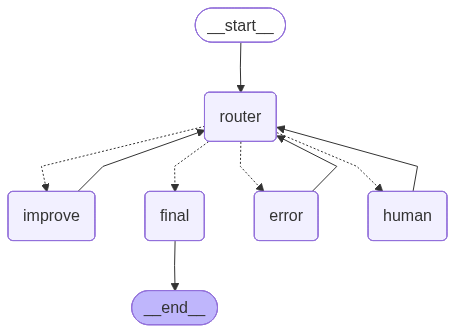

In [2]:
from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())